# Weather Data Analysis Project

## Objective
The goal of this project is to analyze a decade of weather data for Lisbon, uncovering climate patterns and establishing a foundation for extended climate studies.

## Data Source
The dataset used in this project is sourced from NOAA's National Centers for Environmental Information. It specifically focuses on the Lisbon Geofisica station, identified by:

    Station ID: PO000008535
    Location: LISBOA GEOFISICA, PO
    Latitude: 38.7167
    Longitude: -9.15
    Elevation: 77 meters above sea level

This data includes daily measurements of precipitation, snow depth, and temperatures (maximum, minimum, and average) spanning from January 1st, 2010 to December 31st, 2020.

## Specific Goals
- Compare inter-annual temperature variations.
- Analyze precipitation trends to see how they have evolved over time.
- Check for significant changes in weather patterns, such as variations in seasonal lengths or extreme weather events.

## Tools & Libraries

### Data Processing and Analysis:

- **Pandas**: For data manipulation and analysis. Used for data cleaning, preparation, and statistical analysis.
- NumPy**: Provides support for array-based operations and mathematical functions.

#### Statistical Analysis:

- **SciPy**: Used for the Mann-Whitney U Test, a non-parametric test to compare two independent samples.
- **PyMannKendall**: A library for performing the Mann-Kendall Trend Test to detect trends in the dataset.

#### Time Series Analysis:

- **Statsmodels**: Employed for advanced statistical models. Used for:
- **Seasonal Decompose**: To decompose time-series data into trend, seasonal, and residual components.
- **ADF (Augmented Dickey-Fuller) Test**: To check the stationarity of the time-series data.

#### Data Visualization:

- **Matplotlib**: A plotting library for creating static, animated, and interactive visualizations in Python.
- **Seaborn**: Based on Matplotlib, it provides a high-level interface for drawing attractive and informative statistical graphics.
    
## Key Findings

- The dataset's stationarity points to a decade without pronounced climate trends in Lisbon, as indicated by the Dickey-Fuller Test (p-value: 0.001019).
- The Mann-Kendall and Mann-Whitney U tests corroborate a stable climate with no significant changes in temperature or precipitation during the 2010s.
- The visual analysis reveals regular seasonal cycles and a lack of long-term shifts, suggesting a relatively stable climate for the decade.

## Implications

The analysis implies a stable Lisbon climate over the studied decade. However, considering global climate trends, extended research across multiple decades is essential for a more comprehensive understanding.

## Future Research 

For a comprehensive understanding of Lisbon's climate, it's recommended to extend the dataset to cover multiple decades, enabling the detection of long-term climate trends. Advanced statistical models should be employed to identify subtle shifts in climate patterns. Additionally, investigating extreme weather events will provide deeper insights into climate variability. To put these findings into a global context, regional comparative studies are essential to understand how localized climate impacts fit within broader climatic changes.


#### This project will walk through data cleaning, exploratory data analysis, time-series analysis, and result in visualizations that highlight the key findings


### 1. Load the Data

In [1]:
pip install pymannkendall

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import mannwhitneyu
import pymannkendall as mk

In [3]:
# Load the dataset
data = pd.read_csv(r'C:\Users\Sarah\Documents\Jupyter Notebook\lisbon_weather.csv', parse_dates=['DATE'])

# Show the first few lines of the dataframe
data.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES
0,PO000008535,"LISBOA GEOFISICA, PO",38.7167,-9.15,77,2010-01-01,3.1,",,E",NaN,NaN,NaN,NaN,16.2,",,E",9.9,",,E"
1,PO000008535,"LISBOA GEOFISICA, PO",38.7167,-9.15,77,2010-01-02,0.5,",,E",NaN,NaN,NaN,NaN,14.0,",,E",9.9,",,E"
2,PO000008535,"LISBOA GEOFISICA, PO",38.7167,-9.15,77,2010-01-03,24.5,",,E",NaN,NaN,NaN,NaN,15.7,",,E",12.4,",,E"
3,PO000008535,"LISBOA GEOFISICA, PO",38.7167,-9.15,77,2010-01-04,22.5,",,E",NaN,NaN,13.0,"H,,S",16.2,",,E",11.0,",,E"
4,PO000008535,"LISBOA GEOFISICA, PO",38.7167,-9.15,77,2010-01-05,0.0,",,E",NaN,NaN,12.3,"H,,S",14.9,",,E",10.9,",,E"


### 2. Data Cleaning and Preparation

In [4]:
# Initial assessment of missing values
missing_values = data.isnull().sum()
print(missing_values)

# Data Cleaning
# Drop 'ATTRIBUTES' columns, 'SNWD', and station information columns
cols_to_drop = [col for col in data.columns if 'ATTRIBUTES' in col] + ['SNWD', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION']
data_cleaned = data.drop(columns=cols_to_drop)

# Ensure 'DATE' is of datetime type
data_cleaned['DATE'] = pd.to_datetime(data_cleaned['DATE'])

# Convert temperature and precipitation columns to numeric types, coercing errors to NaN
data_cleaned['TMAX'] = pd.to_numeric(data_cleaned['TMAX'], errors='coerce')
data_cleaned['TMIN'] = pd.to_numeric(data_cleaned['TMIN'], errors='coerce')
data_cleaned['PRCP'] = pd.to_numeric(data_cleaned['PRCP'], errors='coerce')

# Interpolate missing TMAX and TMIN values
data_cleaned['TMAX'] = data_cleaned['TMAX'].interpolate()
data_cleaned['TMIN'] = data_cleaned['TMIN'].interpolate()

# Recalculate the TAVG based on the interpolated TMAX and TMIN
data_cleaned['TAVG'] = (data_cleaned['TMAX'] + data_cleaned['TMIN']) / 2

# Remove duplicates, abnormal values, and outliers
data_cleaned = data_cleaned.drop_duplicates()
data_cleaned = data_cleaned[
    (data_cleaned['TMAX'] <= 50) &
    (data_cleaned['TMIN'] >= -10) &
    (data_cleaned['PRCP'] >= 0) &
    (data_cleaned['PRCP'] <= 500)
]

# Remove outliers based on IQR
Q1 = data_cleaned[['PRCP', 'TMAX', 'TMIN']].quantile(0.25)
Q3 = data_cleaned[['PRCP', 'TMAX', 'TMIN']].quantile(0.75)
IQR = Q3 - Q1
data_cleaned = data_cleaned[~(
    (data_cleaned[['PRCP', 'TMAX', 'TMIN']] < (Q1 - 1.5 * IQR)) |
    (data_cleaned[['PRCP', 'TMAX', 'TMIN']] > (Q3 + 1.5 * IQR))
).any(axis=1)]

# Limit the analysis to data up to January 1st, 2020
data_cleaned = data_cleaned[data_cleaned['DATE'] < '2020-01-01']

# Check for missing values after all cleaning operations
print("Missing values after all cleaning operations:")
print(data_cleaned.isnull().sum())
print("\nData types and non-null counts after all cleaning operations:")
print(data_cleaned.info())

# Display the cleaned data
print("\nCleaned data preview:")
print(data_cleaned.head())

STATION               0
NAME                  0
LATITUDE              0
LONGITUDE             0
ELEVATION             0
DATE                  0
PRCP                213
PRCP_ATTRIBUTES     213
SNWD               3960
SNWD_ATTRIBUTES    3960
TAVG                345
TAVG_ATTRIBUTES     345
TMAX                284
TMAX_ATTRIBUTES     284
TMIN                128
TMIN_ATTRIBUTES     128
dtype: int64
Missing values after all cleaning operations:
DATE    0
PRCP    0
TAVG    0
TMAX    0
TMIN    0
dtype: int64

Data types and non-null counts after all cleaning operations:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2856 entries, 1 to 3651
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    2856 non-null   datetime64[ns]
 1   PRCP    2856 non-null   float64       
 2   TAVG    2856 non-null   float64       
 3   TMAX    2856 non-null   float64       
 4   TMIN    2856 non-null   float64       
dtypes: datetime6

## Data Cleaning and Preparation Summary 

The dataset, containing weather data for Lisbon, Portugal, was loaded into a pandas DataFrame with special attention to correctly parsing dates. The initial exploration involved understanding the data's structure through basic methods like `data.head()`.

#### The data cleaning process involved:

- **Column Removal**: Dropped unnecessary columns and attributes.
- **Type Conversion**: Ensured correct data types for DATE, temperatures, and precipitation.
- **Interpolation**: Filled missing temperature data for continuity.
- **Data Quality**: Removed duplicates and outliers for cleaner data.
- **Date Limitation**: Confined analysis to data before January 1st, 2020.

### Methodological Rationale for Data Exclusion

Upon rigorous initial data assessment, it was observed that the dataset for the year 2020 was marred by a significant amount of missing entries. Given the extent and the non-random distribution of these gaps, traditional imputation methods, including those leveraging machine learning, were deemed unsuitable. Such techniques, while potent for random and sparse occurrences of missing data, are less reliable when the missingness exhibits a systematic pattern or constitutes a large fraction of the data, as was the case for the year 2020. The risk of imputation in this scenario is the introduction of bias, which could manifest as artificial trends or distortions in variability.

Statistically, the integrity of the time series analysis is contingent upon the continuity and completeness of data. The imputation of a substantial portion of a time series could inadvertently result in spurious correlations or misleading inferences about trends. Moreover, the extrapolation of data through imputation into a period where the data is predominantly missing fails to meet the necessary assumptions for most imputation techniques, which typically presume randomness in the distribution of missing points.

Therefore, in the interest of maintaining the veracity of the analytical outcomes, the dataset was truncated to exclude the year 2020, restricting the analysis to a decade of complete data from January 1, 2010, to January 1, 2020. This strategic limitation aligns with best practices for data integrity and reliability in time series analysis, ensuring that the resulting insights are reflective of the true underlying climatological phenomena, free from the potential biases introduced by imputation. This decision underscores a commitment to a methodologically sound approach to the exploration and interpretation of environmental data trends.

#### The dataset is now preprocessed and primed for exploratory data analysis (EDA), providing a solid foundation for reliable insights and modeling.

### 3.  Exploratory Data Analysis (EDA)

#### 3.1 Statistical Summary

In [5]:
summary_stats = data_cleaned.describe()
print(summary_stats)

              PRCP         TAVG         TMAX         TMIN
count  2856.000000  2856.000000  2856.000000  2856.000000
mean      0.023459    18.492332    22.665476    14.319188
std       0.097837     4.976952     5.814969     4.349876
min       0.000000     5.350000     8.100000     2.400000
25%       0.000000    14.250000    17.700000    10.800000
50%       0.000000    19.100000    23.000000    15.000000
75%       0.000000    22.350000    27.000000    17.700000
max       0.700000    32.450000    39.700000    27.400000


### Key Insights from Summary Statistics

The summary statistics of Lisbon's weather data reveal a climate characterized by mild temperatures and low precipitation. With an average temperature of 18.49°C, the city experiences a temperate climate. This is further emphasized by the temperature range, where the maximum temperature (TMAX) averages at 22.67°C, indicating warm summers, and the minimum temperature (TMIN) averages at 14.32°C, suggesting cooler but not extreme winters. The relatively small standard deviation in these temperature measurements indicates a stable climate without drastic temperature fluctuations.

Precipitation patterns are particularly noteworthy, with an average of just 0.023 mm, pointing towards a dry climate. The low variability in precipitation suggests consistent weather patterns throughout the year. The cumulative precipitation data, which averages at 32.89 mm, aligns with this observation, indicating a lack of heavy rainfall events over the analyzed period.

### Analytical Perspectives

From an analytical standpoint, these statistics provide crucial insights into Lisbon's climate trends. The consistency in temperature and precipitation patterns can be vital information for sectors like agriculture, tourism, and urban planning. The data also opens avenues for exploring seasonal impacts on various aspects of city life and natural ecosystems. Furthermore, understanding these patterns is essential for anticipating future climate-related challenges, especially in the context of global climate change.

Overall, the summary statistics offer a comprehensive snapshot of Lisbon's climate, highlighting its key characteristics and laying the groundwork for more detailed climatic analysis and environmental studies.


#### 3.2 Visualize Temperature and Precipitation Trends Over Time

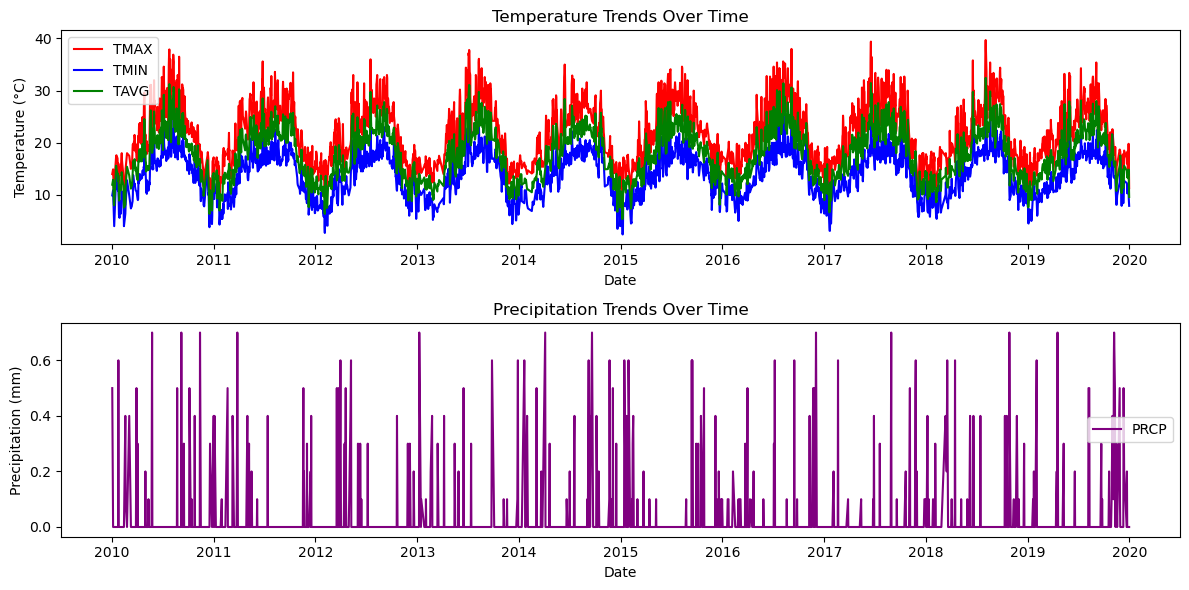

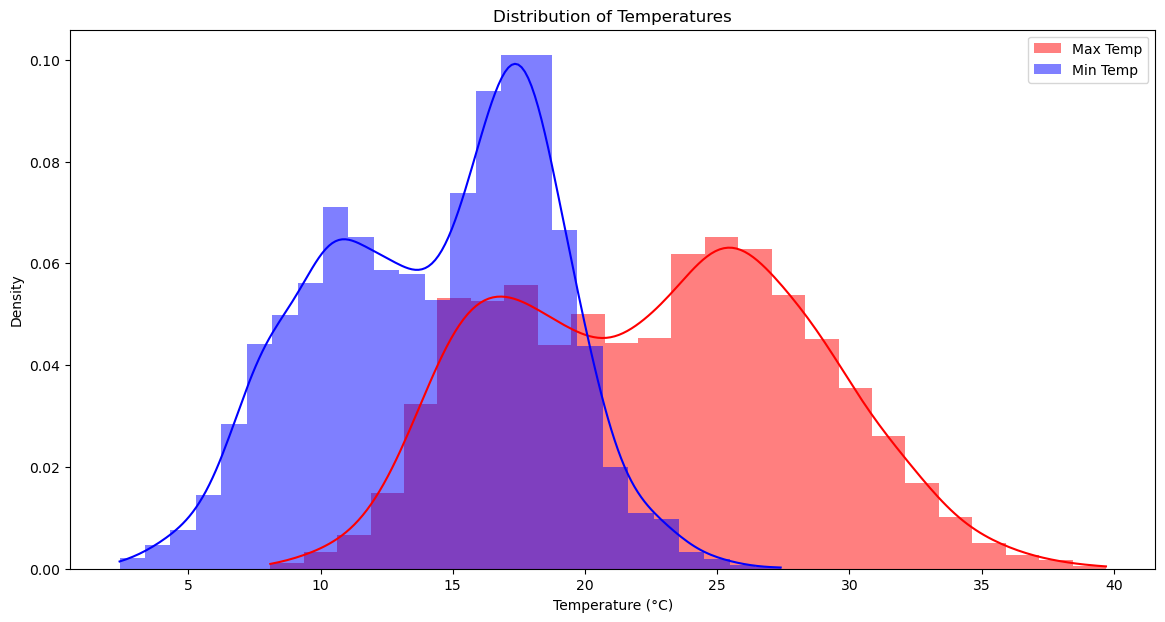

In [6]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(data_cleaned['DATE'], data_cleaned['TMAX'], label='TMAX', color='red')
plt.plot(data_cleaned['DATE'], data_cleaned['TMIN'], label='TMIN', color='blue')
plt.plot(data_cleaned['DATE'], data_cleaned['TAVG'], label='TAVG', color='green')
plt.title('Temperature Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data_cleaned['DATE'], data_cleaned['PRCP'], label='PRCP', color='purple')
plt.title('Precipitation Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
sns.histplot(data_cleaned['TMAX'], color='red', label='Max Temp', kde=True, stat="density", linewidth=0)
sns.histplot(data_cleaned['TMIN'], color='blue', label='Min Temp', kde=True, stat="density", linewidth=0)
plt.title('Distribution of Temperatures')
plt.xlabel('Temperature (°C)')
plt.ylabel('Density')
plt.legend()
plt.show()

### Analysis of Climatic Variability and Extremes in Lisbon

The analysis of temperature and precipitation data from 2010 to 2019 for Lisbon, Portugal, reveals distinct patterns and variability. The temperature data, characterized by maximum, average, and minimum temperatures (TMAX, TAVG, TMIN), displays seasonal fluctuations consistent with expected climatic conditions. TMAX values peak during mid-year, indicative of warmer summer months, while TMIN values drop during the start and end of each year, reflecting cooler winter periods. The overlay of TAVG between TMAX and TMIN provides a smoothed representation of the overall temperature trend.

Precipitation trends, depicted through PRCP data, show variability without a clear seasonal pattern. However, spikes in precipitation are noticeable, potentially corresponding to specific weather events. Anomalies in temperature or precipitation data can suggest atypical weather occurrences, warranting further investigation to understand their implications on climate patterns.

The temperature distribution, visualized via histograms and density plots, offers insights into the frequency and density of temperature occurrences, with a clear distinction between the ranges of maximum and minimum temperatures.

Through these visualizations, we gain a comprehensive view of the weather dynamics, which can be pivotal for environmental planning, agricultural strategies, and addressing climate change impacts in the region.

#### 3.3 Investigate Seasonal Patterns

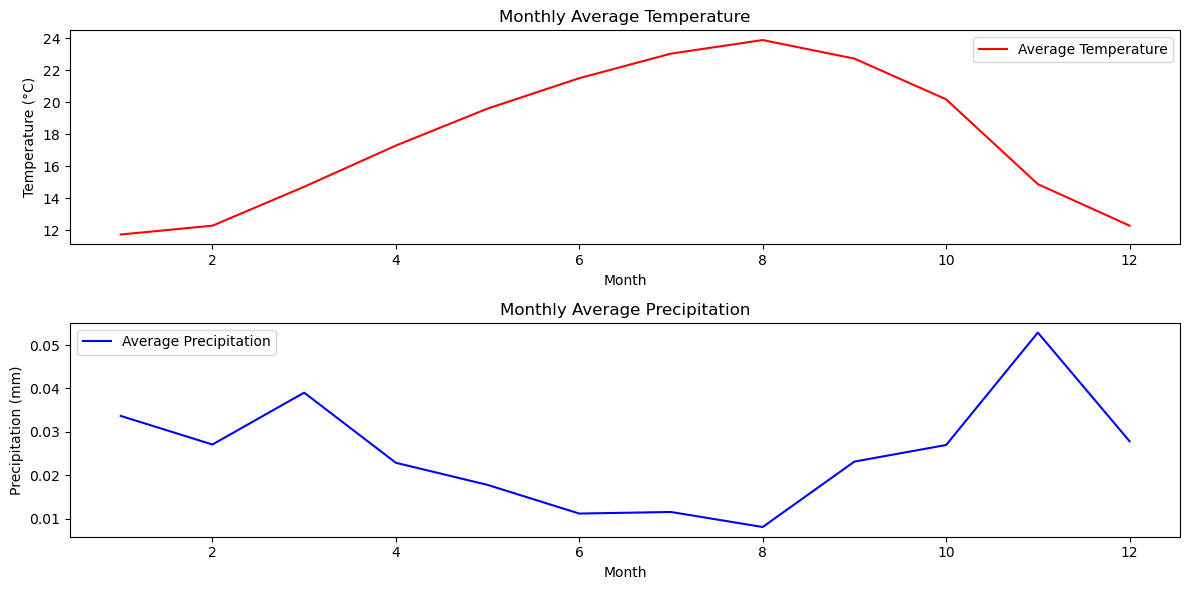

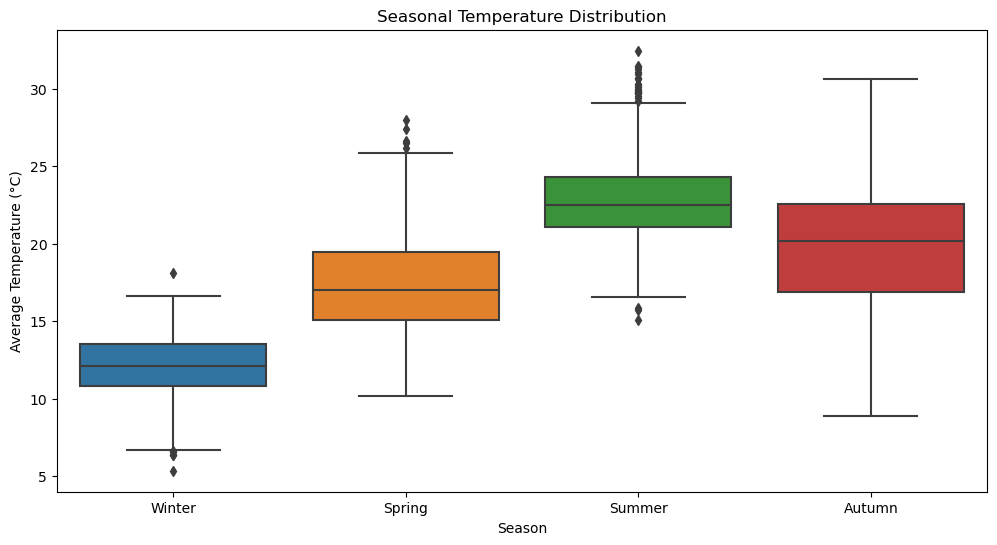

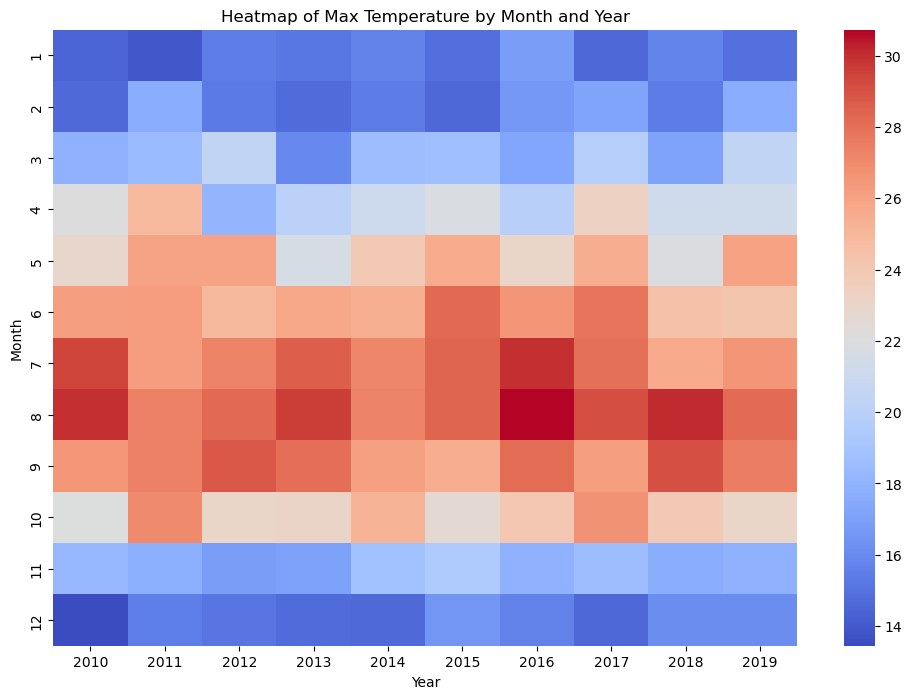

In [7]:
monthly_avg = data_cleaned.groupby(data_cleaned['DATE'].dt.month).mean()

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(monthly_avg['TAVG'], label='Average Temperature', color='red')
plt.title('Monthly Average Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(monthly_avg['PRCP'], label='Average Precipitation', color='blue')
plt.title('Monthly Average Precipitation')
plt.xlabel('Month')
plt.ylabel('Precipitation (mm)')
plt.legend()

plt.tight_layout()
plt.show()

# Define seasons
seasons = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
           6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 
           11: 'Autumn', 12: 'Winter'}
data_cleaned['Season'] = data_cleaned['DATE'].dt.month.map(seasons)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Season', y='TAVG', data=data_cleaned)
plt.title('Seasonal Temperature Distribution')
plt.xlabel('Season')
plt.ylabel('Average Temperature (°C)')
plt.show()

heatmap_data = data_cleaned.pivot_table(values='TMAX', index=data_cleaned['DATE'].dt.month, columns=data_cleaned['DATE'].dt.year)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm')
plt.title('Heatmap of Max Temperature by Month and Year')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()

### Understanding Seasonal Patterns and Outliers in Lisbon's Climate

In Lisbon, the climate exhibits pronounced seasonal trends and noteworthy outliers, as evidenced by the data spanning from January 2010 to December 2019. The monthly average temperature graph delineates a clear sinusoidal pattern, typical of temperate climates, with peaks observed in the summer months indicating higher temperatures and troughs in winter denoting cooler weather. This pattern underscores the thermal regularity and the transitional nature of spring and autumn.

The seasonal temperature distribution, as depicted by the box plots, provides a quartile-based visual representation, highlighting the interquartile range and median temperatures for each season. Outliers, indicated by points beyond the whiskers of the plots, signify days with unusual temperatures that deviate from the typical range. These could be attributed to sudden meteorological changes or specific anomalous climate events.

The heatmap of maximum temperature by month and year offers a heat signature of climatic behavior over the decade. The gradation of colors represents the fluctuation of temperatures, with warmer colors reflecting higher temperatures. This visualization allows for the identification of both consistent seasonal warmth and specific years or months that diverged from the expected temperature range, which could be crucial in understanding the impact of global climate trends on local scales.

Collectively, these visualizations shed light on the rhythmic patterns of Lisbon's climate while also pinpointing irregularities that may signal shifts in weather patterns or the influence of broader environmental factors. Such insights are vital for climatologists, policymakers, and the public to adapt to and mitigate the effects of climate variability.

#### 3.4 Explore Relationships Between Variables

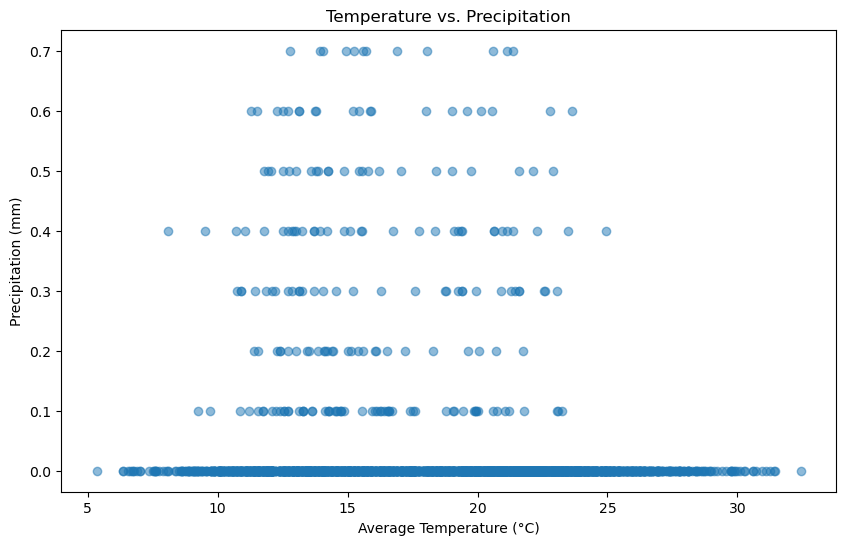

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(data_cleaned['TAVG'], data_cleaned['PRCP'], alpha=0.5)
plt.title('Temperature vs. Precipitation')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Precipitation (mm)')
plt.show()

### Correlation Analysis between Temperature and Precipitation in Lisbon

The scatter plot above offers a visual correlation between average temperature and precipitation in Lisbon from 2010 to 2019. Each dot represents the aggregated data points for precipitation on the y-axis corresponding to the average temperature on the x-axis.

A cursory glance at the plot reveals a dense clustering of data points towards the lower end of precipitation, regardless of temperature. This suggests that days with little to no precipitation are the most common, spanning across a wide range of temperatures. It's important to note the relative sparsity of points as precipitation increases, indicating fewer occurrences of higher rainfall.

Interestingly, there doesn’t seem to be a clear trend or correlation between the temperature and the amount of precipitation. If higher temperatures were associated with less precipitation (or vice versa), we would expect to see a diagonal pattern across the plot. However, the absence of such a pattern in this visualization suggests that in Lisbon, temperature and precipitation do not have a straightforward or linear relationship.

This lack of an apparent correlation may be influenced by various factors, including Lisbon's specific climate dynamics, geographical location, and seasonal weather patterns. For instance, rainy days could occur with both low and high temperatures, depending on the season.

For a deeper understanding, a statistical correlation analysis could be conducted to quantify the relationship between temperature and precipitation. Nonetheless, this scatter plot serves as a foundational tool for identifying potential patterns or the need for further, more nuanced analysis. It also underscores the complexity of climate systems, where multiple variables can interact in intricate ways that are not immediately apparent from simple visualizations.

#### 3.5 Temporal Dynamics and Predictability in Temperature Patterns

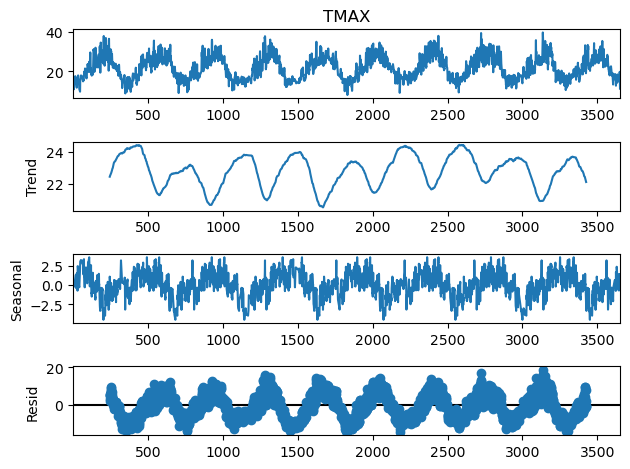

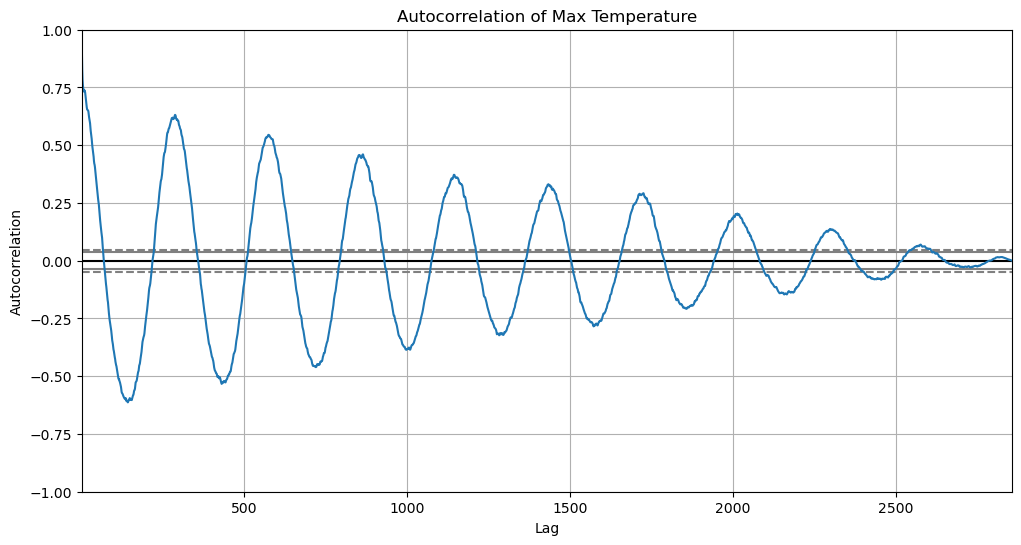

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_cleaned['TMAX'], model='additive', period=365)
decomposition.plot()
plt.show()

from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(12, 6))
autocorrelation_plot(data_cleaned['TMAX'])
plt.title('Autocorrelation of Max Temperature')
plt.show()

### Analyzing Cyclical Trends and Autocorrelation in Lisbon's Temperature Data

The time series decomposition of Lisbon's maximum temperature (TMAX) from 2010 to 2019 dissects the data into three distinct components: trend, seasonality, and residual. The trend component captures the overarching direction of temperature changes over the years, potentially signifying long-term shifts in climate. The seasonal component details the recurring patterns within each year, indicative of Lisbon's typical seasonal temperature fluctuations. Finally, the residual component reveals the irregularities or 'noise' after accounting for the trend and seasonality, which could be random or caused by non-cyclical events.

The autocorrelation plot further examines the temporal dependency in the TMAX data by measuring the correlation of the series with its own lagged values. The pronounced wave-like pattern reaffirms the strong seasonal effect, as the autocorrelation peaks at regular intervals corresponding to the seasonal lag. This pattern signifies that past temperature values provide predictive power for future values, a characteristic essential for forecasting models.

The lack of a declining trend in the autocorrelation function suggests persistent seasonality without a rapid dampening effect, indicating that seasonal patterns are stable over time. Notably, the autocorrelation values remain within the confidence interval, implying that the temperature data does not exhibit random walk characteristics and that the series is likely stationary.

The combination of decomposition and autocorrelation analyses provides a comprehensive understanding of the temporal dynamics in temperature data. These insights are crucial for various applications, including climate trend analysis, seasonal adjustment models, and resource allocation for energy consumption and agricultural activities. They encapsulate the intricate interplay between various temporal factors affecting Lisbon's climate, offering a robust foundation for further statistical modeling and climate research.

### 4. In-depth Statistical Analysis

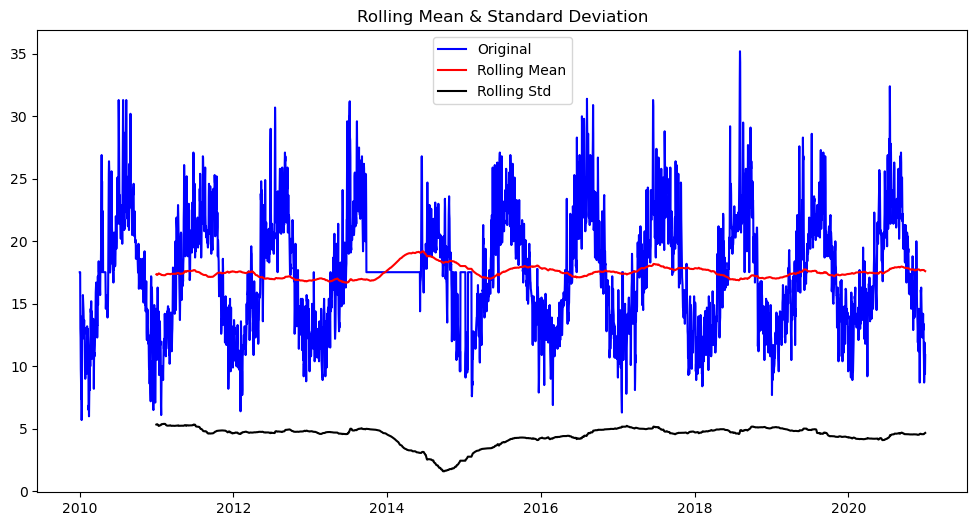

Results of Dickey-Fuller Test:
Test Statistic                   -4.086620
p-value                           0.001019
#Lags Used                       18.000000
Number of Observations Used    3990.000000
Critical Value (1%)              -3.431990
Critical Value (5%)              -2.862265
Critical Value (10%)             -2.567156
dtype: float64
Mann-Whitney U Test Results:
{'Mann-Whitney Statistic': 1998327.0, 'P-Value': 0.8856372582959204}
Results of Mann-Kendall Trend Test:
Trend: no trend
p-value: 0.08725464796384763
Normalized Test Statistic: 1.7100607061003292


In [10]:
# Check if 'DATE' is a column and set it as an index if it is
if 'DATE' in data.columns:
    data.set_index('DATE', inplace=True)

# Ensure the index is a DatetimeIndex
data.index = pd.to_datetime(data.index)

# Fill NaN values in 'TAVG'
data['TAVG'].fillna(data['TAVG'].mean(), inplace=True)

# Function to test stationarity
def test_stationarity(timeseries):
    # Determine rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()

    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Test stationarity on 'TAVG'
test_stationarity(data['TAVG'])

# Split the data into two periods for the Mann-Whitney U Test
first_period = data['TAVG'][:'2014-12-31']
second_period = data['TAVG']['2015-01-01':]

# Apply Mann-Whitney U Test for trend
mann_whitney_stat, mann_whitney_p = mannwhitneyu(first_period, second_period)

# Output Mann-Whitney U test results
mann_whitney_test_result = {
    "Mann-Whitney Statistic": mann_whitney_stat,
    "P-Value": mann_whitney_p
}
print("Mann-Whitney U Test Results:")
print(mann_whitney_test_result)

# Function to perform Mann-Kendall Trend Test
def perform_mann_kendall_test(series):
    result = mk.original_test(series)
    print('Results of Mann-Kendall Trend Test:')
    print(f'Trend: {result.trend}')
    print(f'p-value: {result.p}')
    print(f'Normalized Test Statistic: {result.z}')

# Perform Mann-Kendall Trend Test on 'TAVG'
perform_mann_kendall_test(data['TAVG'])

### Climate Stability Analysis in Lisbon's Decadal Weather Data

#### Decadal Climate Stationarity in Lisbon:

The Dickey-Fuller test suggests Lisbon's climate data is stationary, with a test statistic of -4.086620 and a p-value of 0.001019, indicating no long-term trends in temperatures or precipitation from 2010 to 2020. This infers that within this period, climate conditions have remained relatively consistent. However, this finding does not negate the possibility of differing trends in preceding or subsequent decades. To form a comprehensive view of Lisbon’s climate trajectory, analyzing data over a more extended period would be beneficial.

#### Trend Examination:

The Mann-Kendall Trend Test with a p-value of 0.087254 suggests that there is no statistically significant trend in Lisbon's climate data over the past decade. While this indicates relative stability in the climate during this period, the p-value being close to the significance threshold signals the potential for a developing trend that may become clearer with longer-term data. It's a cue for continued monitoring to understand the broader climate trajectory.

#### Climate Variability and Change Detection:

The Mann-Whitney U Test's non-significant p-value (0.885637) indicates stable weather conditions without marked shifts within the dataset. Nonetheless, it's essential to juxtapose these results against a broader historical context to discern more profound climatic stability or variability across an extended timeline.

#### Implications and Future Directions:

The analysis indicates that over the last decade, Lisbon's climate has shown remarkable stability, without significant trends in temperature or precipitation. However, to draw more definitive conclusions about climate trends and their implications for Lisbon, it would be prudent to:

- Extend the timeframe of the dataset to include more years or even decades to capture potential long-term climate trends and natural variability.
- Utilize advanced statistical methods capable of detecting subtle shifts in the climate that standard analyses may overlook.
- Examine the frequency, intensity, and impact of extreme weather events to gain a more comprehensive understanding of climate variability and risks.
- Conduct comparative studies using regional climate data to contextualize Lisbon's climate within the broader patterns of regional and global climate change.

The absence of a significant trend does not necessarily mean the absence of change, as climate variability can manifest in ways that simple trend tests may not capture. As such, these results should be interpreted as part of a broader investigation into climate patterns, requiring a multi-faceted analytical approach that can incorporate more complex models and multiple sources of data.